In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.3.1


In [12]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [16]:
def windowed_dataset(series, window_size, batch_size, shuffle_size):
    
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_size).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [17]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

## Simple ANN - Linear Regression

In [18]:
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset, epochs=100, verbose=0)

print(f"Layer Weights: {l0.get_weights()}")

Layer Weights: [array([[-0.11326459],
       [ 0.04536243],
       [ 0.0893225 ],
       [-0.0276464 ],
       [ 0.01836509],
       [-0.01091453],
       [-0.02064333],
       [ 0.06011241],
       [-0.01200494],
       [-0.02008057],
       [-0.0560349 ],
       [ 0.07559398],
       [ 0.02562817],
       [-0.04676806],
       [-0.06669584],
       [ 0.12554774],
       [ 0.10821723],
       [ 0.16818017],
       [ 0.2484225 ],
       [ 0.42298487]], dtype=float32), array([0.01621799], dtype=float32)]


## Forecast

In [23]:
import tqdm

In [24]:
def get_forecast(series, window_size, split_time):
    forecast = []

    for time in tqdm.tqdm(range(len(series) - window_size)):
        forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

    forecast = forecast[split_time-window_size:]
    results = np.array(forecast)[:, 0, 0]
    return results

In [25]:
results = get_forecast(series, window_size, split_time)

100%|██████████| 1441/1441 [00:53<00:00, 26.98it/s]


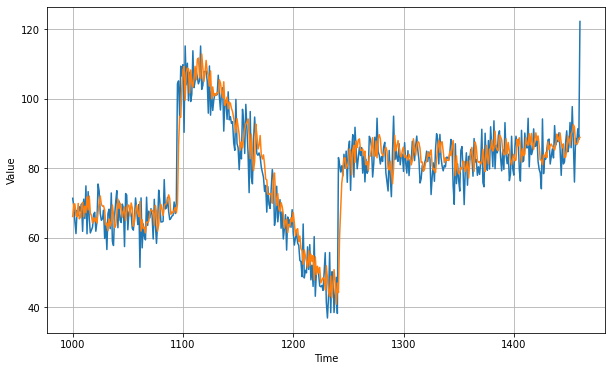

In [26]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [27]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.1578526

## Using DNN

In [51]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [47]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8*10**(epoch/20))

In [48]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9))
history = model.fit(dataset, epochs=100, verbose=0, callbacks=[lr_schedule])

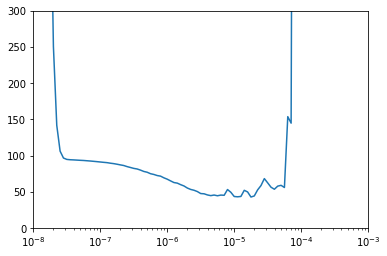

In [49]:
lrs = 1e-8*10**(np.arange(100) /20)
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])
plt.show()

In [55]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [56]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9))
history = model.fit(dataset, epochs=500, verbose=0)

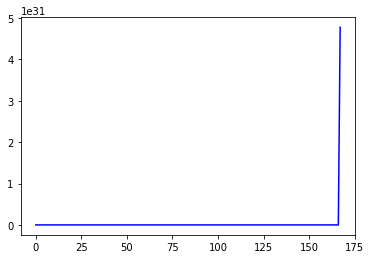

In [57]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[134.7968292236328, 128.46783447265625, 125.1330337524414, 121.9067153930664, 118.6929931640625, 115.30357360839844, 112.10858154296875, 108.84207916259766, 105.77727508544922, 102.72430419921875, 99.98661041259766, 97.07805633544922, 94.26597595214844, 91.65452575683594, 89.58055877685547, 87.5296859741211, 84.99845123291016, 83.24652099609375, 81.0699234008789, 79.44149017333984, 77.26039123535156, 75.01371002197266, 73.77560424804688, 71.5423583984375, 69.85675811767578, 68.2259521484375, 66.2638931274414, 64.64176177978516, 63.07864761352539, 61.371986389160156, 60.06678009033203, 58.25763702392578, 57.66232681274414, 56.54283905029297, 56.26555633544922, 55.97789001464844, 54.25352478027344, 53.671878814697266, 52.384979248046875, 53.27288818359375, 52.94371795654297, 51.35525131225586, 52.10453414916992, 49.644474029541016, 52.18805694580078, 59.74468231201172, 49.518348693847656, 57.94292068481445, 53.25420379638672, 49.88214111328125, 51.21925735473633, 54.260337829589844, 49.3

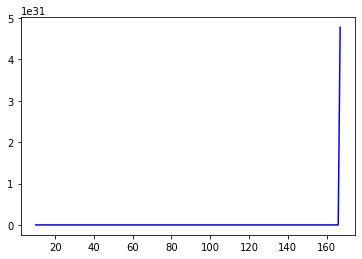

In [58]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

In [ ]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()